In [1]:
import pandas as pd
import numpy as np
from scipy import stats as sp
import sys, os
sys.path.append('../')
import trace_analysis
import plots_analysis
import trace_statistics

# KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
# SVM
from sklearn import svm
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

# Data Preparation


Prepare the data to be used with kNN

In [2]:
plots = [("traces/normal/", 'grid_normal_2019-02-19_21'),
         ("traces/1bh-7/", 'grid_1bh-7_2019-02-19_22'),
         ("traces/1bh-9/", 'grid_1bh-9_2019-02-20_00'),
         ("traces/1gh30-7/", 'grid_1gh30-7_2019-02-19_22'),
         ("traces/1gh30-9/", 'grid_1gh30-9_2019-02-20_00'),
         ("traces/1gh50-7/", 'grid_1gh50-7_2019-02-19_22'),
         ("traces/1gh50-9/", 'grid_1gh50-9_2019-02-19_23'),
         ("traces/1gh70-7/", 'grid_1gh70-7_2019-02-19_23'),
         ("traces/1gh70-9/", 'grid_1gh70-9_2019-02-19_23')
        ]
stats = None
prova = []

for row in plots:
    label = 'Normal'
    
    # Assign a label
    if row[0].find('gh') >= 0:
        label = 'Gray Hole'
    elif row[0].find('bh') >= 0:
        label = 'Black Hole'
    nodes, packets_node = trace_analysis.process_cooja2_traces(row[0], row[1])
    
    # Update stats
    if stats is None:
        stats = trace_statistics.compute_labeled_statistics(nodes, packets_node, label)
    else:
        stats = pd.concat([stats, trace_statistics.compute_labeled_statistics(nodes, packets_node, label)])
    
        
stats = stats.reset_index(drop=True)
stats.head(5)

,node_id,count,mean,var,std,hop,min,max,loss,label
0,aaaa::212:7403:3:303:,148,128.785811,14261.209389,119.420306,1,41.1,947.0,0.740,Normal
1,aaaa::212:7408:8:808:,97,295.701031,73333.878436,270.802287,2,103.0,1809.0,0.485,Normal
2,aaaa::212:7402:2:202:,160,316.326875,100885.449147,317.624699,2,77.9,1858.0,0.800,Normal
3,aaaa::212:740a:a:a0a:,115,433.895652,95800.515332,309.516583,4,188.0,2237.0,0.575,Normal
4,aaaa::212:7409:9:909:,110,549.300000,151722.799083,389.516109,3,168.0,1606.0,0.550,Normal


Select the set of features and labels that we use to fit the algorithm

In [3]:
# separate features from target values
features = stats.drop(columns=['node_id', 'label'])
target = stats['label'].values
print('Targets: ' + str(set(target)))

# split dataset into train and test data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=1)

Targets: {'Normal', 'Black Hole', 'Gray Hole'}


# K-Nearest Neighbor (KNN) Classification

Let us first observe the accuracies for different values of k

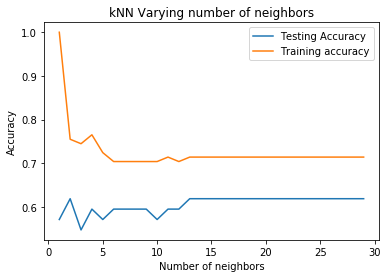

In [4]:
trace_analysis.knn_test_number_of_neighbors(X_train, X_test, y_train, y_test)

Let's build KNN classifier 

In [5]:
#Create KNN Classifier
knn = KNeighborsClassifier(n_neighbors=15)

#Train the model using the training sets
knn.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = knn.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

print("\n\n",classification_report(y_test,y_pred))


Accuracy: 0.6190476190476191


               precision    recall  f1-score   support

  Black Hole       0.00      0.00      0.00        12
   Gray Hole       0.62      1.00      0.76        26
      Normal       0.00      0.00      0.00         4

   micro avg       0.62      0.62      0.62        42
   macro avg       0.21      0.33      0.25        42
weighted avg       0.38      0.62      0.47        42



/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Support Vector Machines (SVM) Classification

Let us experiment with another classifier

In [6]:
#Create a svm Classifier
svm_clf = svm.SVC(kernel='linear', random_state=9, gamma='scale') # Linear Kernel

#Train the model using the training sets
svm_clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = svm_clf.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

print("\n\n",classification_report(y_test,y_pred))

Accuracy: 0.6190476190476191


               precision    recall  f1-score   support

  Black Hole       0.50      0.25      0.33        12
   Gray Hole       0.64      0.88      0.74        26
      Normal       0.00      0.00      0.00         4

   micro avg       0.62      0.62      0.62        42
   macro avg       0.38      0.38      0.36        42
weighted avg       0.54      0.62      0.55        42



/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Random Forests Classifier

Let us experiment with random forests. First, let us select most relevant features.

No handles with labels found to put in legend.


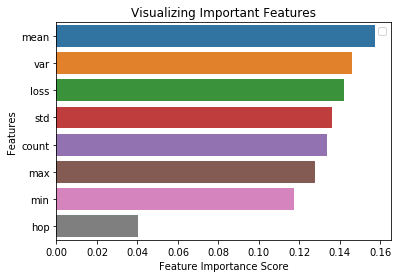

In [7]:
trace_analysis.random_forests_features_selection(X_train, X_test, y_train, y_test, features)

Select relevant features

In [18]:
# separate features from target values
features = stats.drop(columns=['node_id', 'label', 'hop'])
target = stats['label'].values
print('Targets: ' + str(set(target)))

# split dataset into train and test data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=1)

Targets: {'Normal', 'Black Hole', 'Gray Hole'}


Predicted values

In [19]:
#Create a Gaussian Classifier
rf_clf = RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
rf_clf.fit(X_train,y_train)

y_pred = rf_clf.predict(X_test)


print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

print("\n\n",classification_report(y_test,y_pred))

Accuracy: 0.6190476190476191


               precision    recall  f1-score   support

  Black Hole       1.00      0.08      0.15        12
   Gray Hole       0.62      0.96      0.76        26
      Normal       0.00      0.00      0.00         4

   micro avg       0.62      0.62      0.62        42
   macro avg       0.54      0.35      0.30        42
weighted avg       0.67      0.62      0.51        42

